In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly
import plotly.subplots as sp
import plotly.io as pio
import os
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
import meshparty
from meshparty import trimesh_vtk, trimesh_io 
from scipy.spatial import KDTree

vol =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
client = CAVEclient('zheng_ca3')

isotropy = [5,5,2]


In [3]:
# requires 6GB memory
filepath = './data/test_assign_output_20240722181157_final_edgelist.df'
syn_table = pd.read_csv(filepath,  dtype={'centroid_x':float,'centroid_y':float,'centroid_z':float,'cleft_segid':str, 'size':int})

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/401746833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_syn_table['centroid_x'] = large_syn_table['centroid_x'].astype(int)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/401746833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_syn_table['centroid_y'] = large_syn_table['centroid_y'].astype(int)
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/401746833.py:4: SettingWithCopyWarning: 
A va

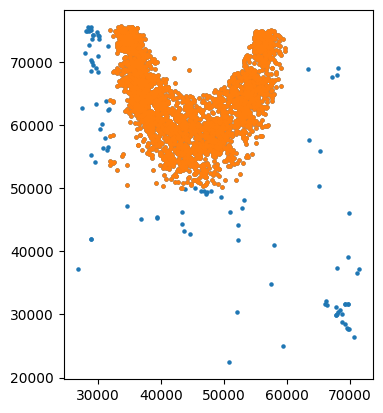

In [4]:
large_syn_table = syn_table[syn_table['size'] > 10000]
large_syn_table['centroid_x'] = large_syn_table['centroid_x'].astype(int)
large_syn_table['centroid_y'] = large_syn_table['centroid_y'].astype(int)
large_syn_table['centroid_z'] = large_syn_table['centroid_z'].astype(int)

plt.scatter(large_syn_table['centroid_x'], large_syn_table['centroid_y'], s=5)
large_syn_df = large_syn_table[(large_syn_table['centroid_y'] > 50000) & (large_syn_table['centroid_x'] < 60000)& (large_syn_table['centroid_x'] > 32000)]
plt.scatter(large_syn_df['centroid_x'], large_syn_df['centroid_y'], s=5)
ax = plt.gca()
ax.set_aspect('equal')

In [5]:
del syn_table # free up memory

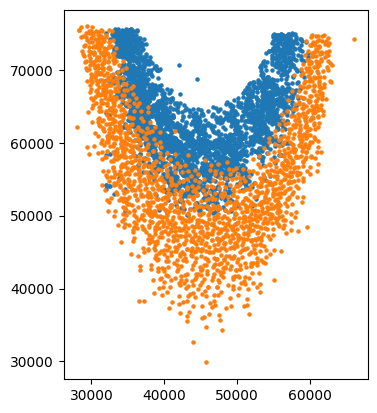

In [6]:
PC_nucleus_file_path = './data/all_pyramidal_cells_v2.csv'
table = pd.read_csv(PC_nucleus_file_path, dtype={'x':int, 'y':int, 'z':int, 'nuclei_id':str})
nuclei_coord = table[['x','y','z']].to_numpy()
syn_coord = large_syn_df[['centroid_x','centroid_y','centroid_z']].to_numpy()

plt.scatter(large_syn_df['centroid_x'], large_syn_df['centroid_y'], s=5)
plt.scatter(table['x'], table['y'], s=5)
ax = plt.gca()
ax.set_aspect('equal')



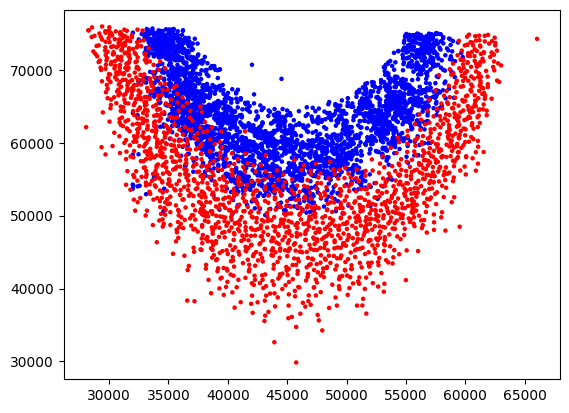

In [11]:
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

X = np.vstack((syn_coord,nuclei_coord))
Y = np.hstack((np.zeros(len(syn_coord)), np.ones(len(nuclei_coord))))

svm_clf = SVC(kernel='rbf', C=1.0)
svm_clf.fit(X,Y)
plt.scatter(X[:,0], X[:,1], s=5, c=Y, cmap='bwr', marker='o')
xx, yy, zz = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 50),
                     np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 50),
                     np.linspace(X[:, 2].min()-1, X[:, 2].max()+1, 50))
grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
#decision_values = svm_clf.decision_function(grid_points).reshape(xx.shape)
decision_values = svm_clf.decision_function(grid_points)


In [25]:
import trimesh
print(type(mesh))
print(type(mesh.vertices[0][0]))
print(type(mesh.faces[0][0]))
print(mesh.vertices.shape)
print(mesh.faces.shape)
tmesh = trimesh.Trimesh(vertices=mesh.vertices, faces=mesh.faces)


<class 'cloudvolume.mesh.Mesh'>
<class 'numpy.float32'>
<class 'numpy.uint32'>
(1749115, 3)
(3452562, 3)


In [10]:
import trimesh.transformations as tra

def mesh_downsample(m, voxel_size):
    
    # Downsample mesh vertices using a voxel grid and update faces accordingly.
    vertices = m.vertices
    faces = m.faces
    min_coords = vertices.min(axis=0)
    voxel_indices = np.floor((vertices - min_coords) / voxel_size).astype(np.int32)
    
    # Dictionary mapping voxel index (tuple) to list of original vertex indices
    voxel_dict = {}
    for i, voxel in enumerate(voxel_indices):
        key = tuple(voxel)
        if key not in voxel_dict:
            voxel_dict[key] = []
        voxel_dict[key].append(i)
    
    new_vertices_list = []
    mapping = np.empty(vertices.shape[0], dtype=np.int32)
    
    # For each voxel, compute the average vertex coordinate and update mapping.
    for new_idx, (key, indices) in enumerate(voxel_dict.items()):
        avg_vertex = vertices[indices].mean(axis=0)
        new_vertices_list.append(avg_vertex)
        for idx in indices:
            mapping[idx] = new_idx
            
    new_vertices = np.array(new_vertices_list)
    new_faces = mapping[faces]
    valid_face_mask = np.apply_along_axis(lambda f: len(set(f)) == 3, 1, new_faces)
    new_faces = new_faces[valid_face_mask]
    
    mesh = trimesh.Trimesh(vertices = new_vertices, faces=new_faces)
    return mesh


    


def enlarge_mesh_at_fixed_pos(mesh, scale_factor):
    centroid = mesh.centroid
    T1 = tra.translation_matrix(-centroid)
    S = np.eye(4)
    S[0,0] = scale_factor
    S[1,1] = scale_factor
    S[2,2] = scale_factor
    T2 = tra.translation_matrix(centroid)
    transform = tra.concatenate_matrices(T2, S, T1)
    mesh.apply_transform(transform)
    return mesh

In [94]:
import pygsheets

gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet2 = gc.open('nuclei_table_250217')
worksheet2 = sheet2.worksheet('title','nuclei')
nuc_df = worksheet2.get_as_df(start='A1')

/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning:

At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.



In [97]:
nuc_df_inh = nuc_df[nuc_df['group']=='inh']
nuc_df_pyc = nuc_df[nuc_df['group']=='pyr']

nuclei_coord_inh = nuc_df_inh[['x','y','z']].to_numpy()
nuclei_coord_pyc = nuc_df_pyc[['x','y','z']].to_numpy()


In [12]:
import plotly.graph_objs as go
import trimesh

#grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
#decision_values = svm_clf.decision_function(grid_points)
#boundary_coord = grid_points[np.abs(decision_values) < 0.2]
boundary_coord = grid_points[((decision_values < 0) & (decision_values > -0.3))]

#pyc_id = client.chunkedgraph.suggest_latest_roots([648518346440971223,648518346450344364])
pyc_id1 = client.chunkedgraph.suggest_latest_roots(648518346449428431)
pyc_id2 = client.chunkedgraph.suggest_latest_roots(648518346446492124)
pyc_id3 = client.chunkedgraph.suggest_latest_roots(648518346447553683)
mf_id = client.chunkedgraph.suggest_latest_roots(648518346436441623)

ds_rate=10
mesh = vol.mesh.get(pyc_id1)[pyc_id1]   
mesh.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh = mesh_downsample(mesh, ds_rate)
mesh = enlarge_mesh_at_fixed_pos(mesh, 1.05)

mesh2 = vol.mesh.get(pyc_id2)[pyc_id2]   
mesh2.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh2 = mesh_downsample(mesh2, ds_rate)
mesh2 = enlarge_mesh_at_fixed_pos(mesh2, 1.05)

mesh3 = vol.mesh.get(pyc_id3)[pyc_id3]   
mesh3.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh3 = mesh_downsample(mesh3, ds_rate)
mesh3 = enlarge_mesh_at_fixed_pos(mesh3, 1.05)

mesh4 = vol.mesh.get(mf_id)[mf_id]   
mesh4.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh4 = mesh_downsample(mesh4, 5)
mesh4 = enlarge_mesh_at_fixed_pos(mesh4, 1.05)

(array([  3.,  36., 130., 256., 374., 321., 233., 187., 165., 135.]),
 array([29856. , 34465.6, 39075.2, 43684.8, 48294.4, 52904. , 57513.6,
        62123.2, 66732.8, 71342.4, 75952. ]),
 <BarContainer object of 10 artists>)

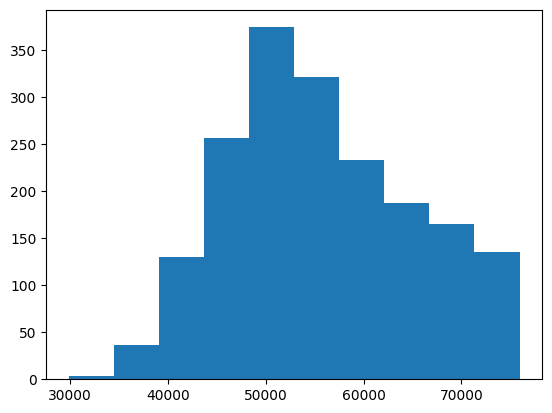

In [49]:
plt.hist(nuclei_coord[:,1])

In [90]:
mf_id = client.chunkedgraph.suggest_latest_roots(648518346436441623)

mesh4 = vol.mesh.get(mf_id)[mf_id]   
mesh4.vertices //= ((vol.meta.resolution(0)) * [1,1,1])
mesh4 = mesh_downsample(mesh4, 5)
mesh4 = enlarge_mesh_at_fixed_pos(mesh4, 1.05)

In [113]:
# draw figure for paper

navy = 'rgb(26,50,96)'
green = 'rgb(160,210,140)'
skyblue = 'rgb(100,180,220)'

syn = go.Scatter3d(x=syn_coord[:,1], y=syn_coord[:,0], z=syn_coord[:,2]-2000, mode='markers',
                   marker=dict(size=1, color=green, opacity=0.6), name='syn locations')
nuclei_pyc = go.Scatter3d(x=nuclei_coord_pyc[:,1], y=nuclei_coord_pyc[:,0], z=nuclei_coord_pyc[:,2]-2000, mode='markers',
                      marker=dict(size=2.5, color='rgb(26,50,96)', opacity=0.3), name='nuclei locations')
nuclei_inh = go.Scatter3d(x=nuclei_coord_inh[:,1], y=nuclei_coord_inh[:,0], z=nuclei_coord_inh[:,2]-2000, mode='markers',
                      marker=dict(size=2.5, color='rgb(240,35,35)',opacity=0.3), name='nuclei locations')

#boundary = go.Scatter3d(x=boundary_coord[:,0], y=boundary_coord[:,1], z=boundary_coord[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(60,50,60)',opacity=0.5), name='boundary')

mesh_go = go.Mesh3d(x=mesh.vertices[:,1],y=mesh.vertices[:,0],z=mesh.vertices[:,2],
                    i=mesh.faces[:,1],j=mesh.faces[:,0],k=mesh.faces[:,2],color=navy)
mesh_go2 = go.Mesh3d(x=mesh2.vertices[:,1],y=mesh2.vertices[:,0],z=mesh2.vertices[:,2],
                     i=mesh2.faces[:,1],j=mesh2.faces[:,0],k=mesh2.faces[:,2],color='rgb(160,80,160)')
mesh_go3 = go.Mesh3d(x=mesh3.vertices[:,1],y=mesh3.vertices[:,0],z=mesh3.vertices[:,2],
                     i=mesh3.faces[:,1],j=mesh3.faces[:,0],k=mesh3.faces[:,2],color='rgb(240,30,30)')
mesh_go4 = go.Mesh3d(x=mesh4.vertices[:,1],y=mesh4.vertices[:,0],z=mesh4.vertices[:,2],
                     i=mesh4.faces[:,1],j=mesh4.faces[:,0],k=mesh4.faces[:,2],color='rgb(255,140,0)')

scale_bar = go.Scatter3d(x=[72000,72000], y=[20000,25555], z=[1000,1000], mode="lines+text",
                         line=dict(color="black", width=3))

fig = go.Figure(data=[nuclei_pyc,nuclei_inh,syn,mesh_go,mesh_go2, mesh_go3, mesh_go4, scale_bar])
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50),
                  scene=dict(camera=dict(eye=dict(x=0., y=0., z=3)),
                  xaxis=dict(autorange="reversed"),yaxis=dict(autorange="reversed"),
                  zaxis=dict(range=[-2000, 2400]),aspectmode="data"),showlegend=False)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
#fig.update_scenes(zaxis_visible=False)

#plotly.offline.plot(fig, filename='/Users/cp8083/princeton/hippocampus/code/ca3/pyr_layer_boundary.html')
fig.write_image("./fig/paper01/dataset_xy_view.png",format="png", scale=6)

'''

'''

"\nfig2d = plt.figure(figsize=(6,6))\nboundary_coord2 = boundary_coord[(boundary_coord[:,2] < 1950) & (boundary_coord[:,2] > 100)]\nsyn_coord2 = syn_coord[(syn_coord[:,2] < 1950) & (syn_coord[:,2]> 100)]\nnuclei_coord2 = nuclei_coord[(nuclei_coord[:,2] < 1950) & (nuclei_coord[:,2] > 100)]\nplt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')\nplt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')\nplt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=6, c=[0,0.5,0.82],marker='o')\n"

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/1466400204.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/1466400204.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')
/va

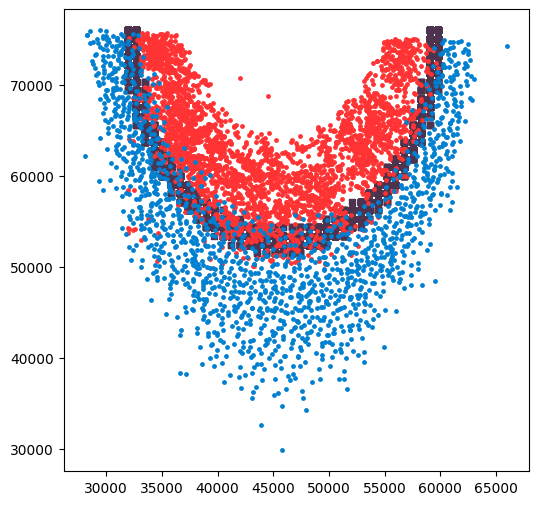

In [14]:
fig2d = plt.figure(figsize=(6,6))
boundary_coord2 = boundary_coord[(boundary_coord[:,2] < 1950) & (boundary_coord[:,2] > 100)]
syn_coord2 = syn_coord[(syn_coord[:,2] < 1950) & (syn_coord[:,2]> 100)]
nuclei_coord2 = nuclei_coord[(nuclei_coord[:,2] < 1950) & (nuclei_coord[:,2] > 100)]
plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=20, c=[0.3,0.2,0.3], marker='s')
plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=6, c=[1,0.2,0.2], marker='o')
plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=6, c=[0,0.5,0.82],marker='o')

In [86]:
plt.figure(figsize=(9,9))
plt.scatter(syn_coord[:,0], syn_coord[:,1], s=5, c=[0.62,0.85,0.55], marker='o')
plt.scatter(nuclei_coord[:,0], nuclei_coord[:,1], s=7, c=[0.4,0.7,0.9],marker='o')

v1 = mesh.vertices[:,:2]
v2 = mesh2.vertices[:,:2]
v3 = mesh3.vertices[:,:2]

for face in mesh.faces:
    f1 = v1[face]
    plt.fill(f1[:,0], f1[:,1], facecolor=[0.1,0.2,0.4])
for face in mesh2.faces:
    f1 = v2[face]
    plt.fill(f1[:,0], f1[:,1], facecolor=[0.62,0.3,0.62])
for face in mesh.faces:
    f1 = v3[face]
    plt.fill(f1[:,0], f1[:,1], facecolor=[0.95,0.15,0.15])

plt.set_aspect('equal')
plt.grid(True)
plt.show()

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_92446/695958524.py:2: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_92446/695958524.py:3: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10eff0a60>>
Traceback (most recent call last):


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/436519519.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=30, c=[0.3,0.25,0.3], marker='s')
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/436519519.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=7, c=[0.55,0.78,0.45], marker='o'

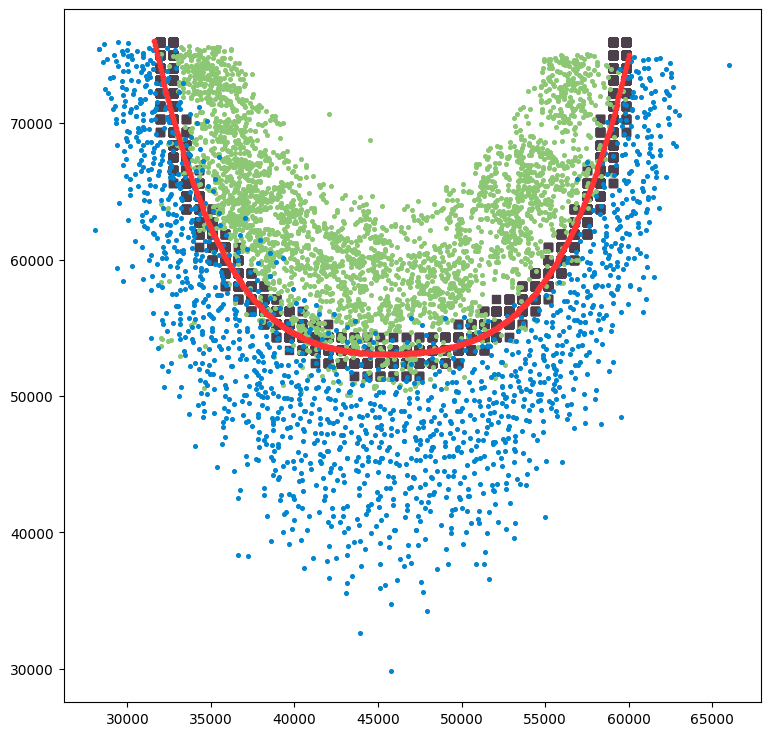

In [15]:
# fit a 2d curve to the xy projected boundary

degree =4
coeff = np.polyfit(boundary_coord2[:,0], boundary_coord2[:,1], degree)
polynomial = np.poly1d(coeff)
x_curve = np.linspace(min(boundary_coord2[:,0])-360, max(boundary_coord2[:,0])+180, 500)
y_curve = polynomial(x_curve)
plt.figure(figsize=(9,9))
plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=30, c=[0.3,0.25,0.3], marker='s')
plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=7, c=[0.55,0.78,0.45], marker='o')
plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=7, c=[0,0.52,0.82],marker='o')
plt.scatter(x_curve,y_curve,s=10,c=[1,0.2,0.2],marker='o')
plt.show()





In [208]:
print(polynomial)

           4             3            2
3.922e-13 x - 7.211e-08 x + 0.005003 x - 155.2 x + 1.869e+06


In [199]:
# map nuclei to boundary curve and fidn the position/distance along the curve

from scipy.integrate import quad
poly_derivative = np.polyder(polynomial)
def arc_length(x_pos):
    return np.sqrt(1+ (poly_derivative(x_pos))**2)

def euclidean_dist(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1] - p2[1])**2)

x_start = min(boundary_coord2[:,0])-360
curve_points = np.column_stack((x_curve, y_curve))
nuclei_distance_along_curve = []

for p1 in nuclei_coord[:,:2]:
    dd = [euclidean_dist(p1,p2) for p2 in curve_points]
    nearest_curve_pnt = curve_points[np.argmin(dd)] 
    curve_distance, err = quad(arc_length, x_start, nearest_curve_pnt[0])
    nuclei_distance_along_curve.append(curve_distance)

nuclei_distance_along_curve = np.array(nuclei_distance_along_curve)*18/1000      

In [207]:
#plt.hist(nuclei_distance_along_curve)

#print(table)
table['curve_distance'] = nuclei_distance_along_curve
table.to_csv('pyramidal_cells_with_curve_distance.csv', index=False)

                     source  Unnamed: 0          nuclei_id      x      y  \
0     1.pyramidal_cell_list      9001.0  72621781411693849  37360  57056   
1     1.pyramidal_cell_list     18690.0  73114225181987939  52608  53328   
2     1.pyramidal_cell_list     11628.0  72762381461095631  42464  53440   
3     1.pyramidal_cell_list     22974.0  73325743731377517  57984  65376   
4     1.pyramidal_cell_list     10370.0  72692150155870913  38848  57520   
...                     ...         ...                ...    ...    ...   
1835   inhibitory_cell_list       295.0  72902568723874012  46112  36544   
1836   inhibitory_cell_list       332.0  73113812395360259  51536  39952   
1837   inhibitory_cell_list       308.0  72973006187528237  49072  38768   
1838   inhibitory_cell_list       280.0  72832268699172868  43568  39312   
1839   inhibitory_cell_list       210.0  72410537270444036  31440  54240   

         z Coordinates (concatenate) Coordinates (value only)  \
0     2063            

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_44810/1390689387.py:15: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



(array([772., 516., 255., 133.,  83.,  47.,  24.,   8.,   1.,   1.]),
 array([  0.90023826,  39.798575  ,  78.69691173, 117.59524847,
        156.4935852 , 195.39192194, 234.29025867, 273.18859541,
        312.08693214, 350.98526888, 389.88360561]),
 <BarContainer object of 10 artists>)

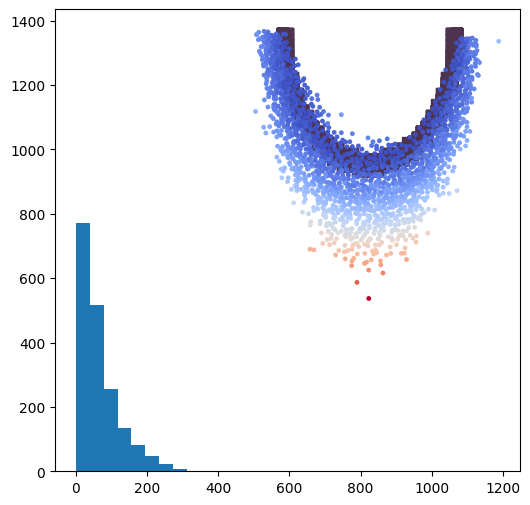

In [138]:
# get distances between nuclei and the boundary
from scipy.spatial import KDTree
import copy

ncoord = copy.deepcopy(nuclei_coord)
bcoord = copy.deepcopy(boundary_coord)

ncoord[:,0] = ncoord[:,0] * 18 / 1000
ncoord[:,1] = ncoord[:,1] * 18 / 1000
ncoord[:,2] = ncoord[:,2] * 45 / 1000
bcoord[:,0] = bcoord[:,0] * 18 / 1000
bcoord[:,1] = bcoord[:,1] * 18 / 1000
bcoord[:,2] = bcoord[:,2] * 45 / 1000

tree = KDTree(boundary_coord)
distances, _ = tree.query(ncoord)

fig2d = plt.figure(figsize=(6,6))
plt.scatter(bcoord[:,0], bcoord[:,1], s=20, c=[0.3,0.2,0.3], marker='s')
#plt.scatter(syn_coord[:,0], syn_coord[:,1], s=6, c=[1,0.2,0.2], marker='o')
plt.scatter(ncoord[:,0], ncoord[:,1], s=6, c=distances, cmap='coolwarm', marker='o')


In [135]:
table['depth_microns'] = distances
table.to_csv('pyramidal_cells_with_depth.csv', index=False)

In [16]:
# draw two more boundaries: oriens_pyramidal and lucidum_radiatum

from scipy.spatial import cKDTree

tree1 = cKDTree(syn_coord)
tree2 = cKDTree(nuclei_coord)
d_thresh = 800
num_rand_pnts = 20000
min_bounds = np.min(np.vstack((syn_coord, nuclei_coord)),axis=0) - 2
max_bounds = np.max(np.vstack((syn_coord, nuclei_coord)),axis=0) + 2
rand_pnts = np.random.uniform(min_bounds, max_bounds, size=(num_rand_pnts, 3))
d_to_syn, _ = tree1.query(rand_pnts)
d_to_nuclei, _ = tree2.query(rand_pnts)
fake_points = rand_pnts[(d_to_syn > d_thresh) & (d_to_nuclei > d_thresh)]

decision_values3 = svm_clf.decision_function(fake_points)
fake_points1 = fake_points[(decision_values3 > 0)]
fake_points2 = fake_points[(decision_values3 < 0)]
fake_points1 = fake_points1[:len(fake_points)//4]

X2 = np.vstack((fake_points2,syn_coord))
Y2 = np.hstack((np.zeros(len(fake_points2)), np.ones(len(syn_coord))))
svm_clf2 = SVC(kernel='rbf', C=2.0)
svm_clf2.fit(X2,Y2)
xx2, yy2, zz2 = np.meshgrid(np.linspace(X2[:, 0].min()-1, X2[:, 0].max()+1, 50),
                     np.linspace(X2[:, 1].min()-1, X2[:, 1].max()+1, 50),
                     np.linspace(X2[:, 2].min()-1, X2[:, 2].max()+1, 50))
grid_points2 = np.c_[xx2.ravel(), yy2.ravel(), zz2.ravel()]
decision_values4 = svm_clf2.decision_function(grid_points2)
lucidum_radiatum = grid_points2[((decision_values4 < 0.1) & (decision_values4 > -0.1))]
boundary2 = go.Scatter3d(x=lucidum_radiatum[:,0], y=lucidum_radiatum[:,1], z=lucidum_radiatum[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(60,50,60)',opacity=0.5), name='boundary')

X3 = np.vstack((nuclei_coord,fake_points1))
Y3 = np.hstack((np.zeros(len(nuclei_coord)), np.ones(len(fake_points1))))
svm_clf3 = SVC(kernel='rbf', C=1.0)
svm_clf3.fit(X3,Y3)
xx3, yy3, zz3 = np.meshgrid(np.linspace(X3[:, 0].min()-1, X3[:, 0].max()+1, 50),
                     np.linspace(X3[:, 1].min()-1, X3[:, 1].max()+1, 50),
                     np.linspace(X3[:, 2].min()-1, X3[:, 2].max()+1, 50))
grid_points3 = np.c_[xx3.ravel(), yy3.ravel(), zz3.ravel()]
decision_values5 = svm_clf3.decision_function(grid_points3)
oriens_pyramidal = grid_points3[((decision_values5 < 0.1) & (decision_values5 > -0.1))]
boundary3 = go.Scatter3d(x=oriens_pyramidal[:,0], y=oriens_pyramidal[:,1], z=oriens_pyramidal[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(60,50,60)',opacity=0.5), name='boundary')


/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/4155694406.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=7, c=[0.55,0.78,0.45], marker='o')
/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_88589/4155694406.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=7, c=[0,0.52,0.82],marker='o')
/v

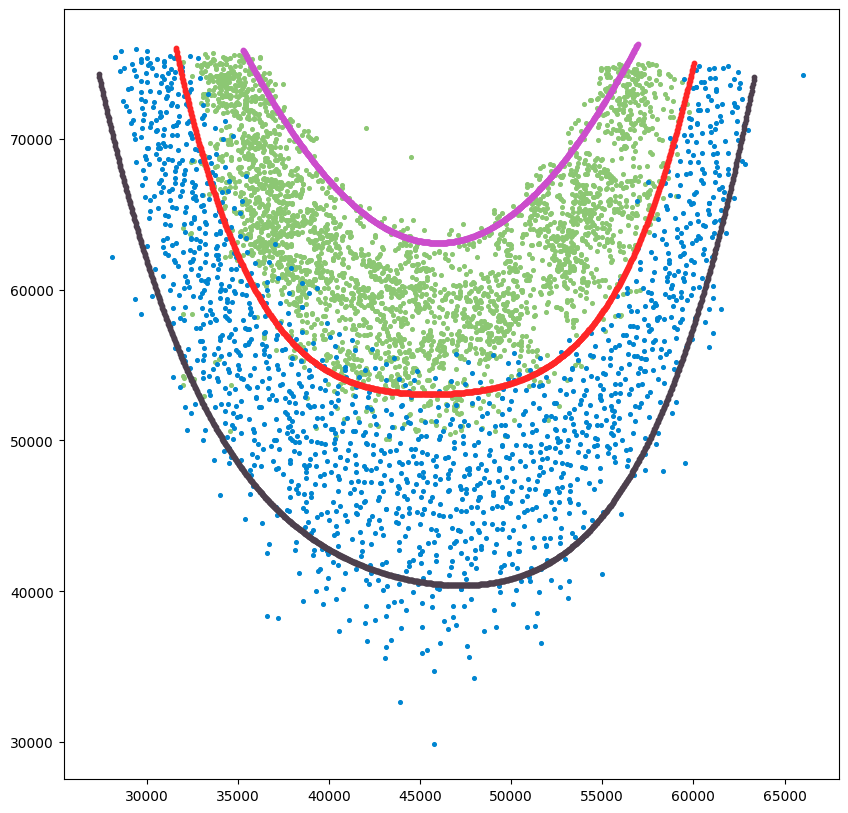

In [17]:
# fit a 2d curves to the xy projected boundaries

degree =4

coeff1 = np.polyfit(lucidum_radiatum[:,0], lucidum_radiatum[:,1], degree)
polynomial1 = np.poly1d(coeff1)
x_curve1 = np.linspace(min(lucidum_radiatum[:,0])-60, max(lucidum_radiatum[:,0]), 1000)
y_curve1 = polynomial1(x_curve1)

coeff2 = np.polyfit(boundary_coord2[:,0], boundary_coord2[:,1], degree)
polynomial2 = np.poly1d(coeff2)
x_curve2 = np.linspace(min(boundary_coord2[:,0])-360, max(boundary_coord2[:,0])+180, 1000)
y_curve2 = polynomial2(x_curve2)

coeff3 = np.polyfit(oriens_pyramidal[:,0], oriens_pyramidal[:,1], degree)
polynomial3 = np.poly1d(coeff3)
x_curve3 = np.linspace(min(oriens_pyramidal[:,0])-700, max(oriens_pyramidal[:,0])+400, 1000)
y_curve3 = polynomial3(x_curve3)

plt.figure(figsize=(10,10))
#plt.scatter(boundary_coord2[:,0], boundary_coord2[:,1], s=30, c=[0.3,0.25,0.3], marker='s')
plt.scatter(syn_coord2[:,0], syn_coord2[:,1], s=7, c=[0.55,0.78,0.45], marker='o')
plt.scatter(nuclei_coord2[:,0], nuclei_coord2[:,1], s=7, c=[0,0.52,0.82],marker='o')
plt.scatter(x_curve1,y_curve1,s=10,c=[0.8,0.3,0.8],marker='o')
plt.scatter(x_curve2,y_curve2,s=10,c=[1,0.15,0.15],marker='o')
plt.scatter(x_curve3,y_curve3,s=10,c=[0.3,0.25,0.3],marker='o')
plt.savefig('layer_boundaries_high_res.png', dpi=900)
plt.show()
plt.close()

import pickle
with open("./variables/layer_boundary_equations.pkl", "wb") as file:
    pickle.dump([x_curve1, y_curve1, x_curve2, y_curve2, x_curve3, y_curve3], file)

In [19]:
import pickle
with open("./variables/layer_boundary_equations.pkl", "wb") as file:
    pickle.dump([x_curve1, y_curve1, x_curve2, y_curve2, x_curve3, y_curve3], file)

In [286]:
syn = go.Scatter3d(x=syn_coord[:,0], y=syn_coord[:,1], z=syn_coord[:,2], mode='markers',marker=dict(size=4, color='rgb(132,190,110)'), name='syn locations')
nuclei = go.Scatter3d(x=nuclei_coord[:,0], y=nuclei_coord[:,1], z=nuclei_coord[:,2], mode='markers',marker=dict(size=4, color='rgb(0,140,210)'), name='nuclei locations')
boundary = go.Scatter3d(x=boundary_coord[:,0], y=boundary_coord[:,1], z=boundary_coord[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(60,50,60)',opacity=0.5), name='boundary')
space_filler1 = go.Scatter3d(x=fake_points1[:,0], y=fake_points1[:,1], z=fake_points1[:,2], mode='markers', name='fake_points', marker=dict(size=4, color='rgb(250,210,50)') )
space_filler2 = go.Scatter3d(x=fake_points2[:,0], y=fake_points2[:,1], z=fake_points2[:,2], mode='markers', name='fake_points', marker=dict(size=4, color='rgb(250,210,50)') )

#test = fake_points[(decision_values3 > 0)]
#test = grid_points2[(decision_values4 > 0)]
#test = grid_points3[(decision_values5 > 0)]
#test = grid_points[(decision_values > 0)]
#test_go = go.Scatter3d(x=test[:,0], y=test[:,1], z=test[:,2], mode='markers',marker=dict(size=6,symbol='square',color='rgb(250,50,60)',opacity=0.5), name='test')
#fig = go.Figure(data=[syn,nuclei,boundary,boundary2,boundary3,test_go])

fig = go.Figure(data=[syn,nuclei,boundary,boundary2,boundary3,space_filler1,space_filler2])
fig.update_layout(scene=dict(zaxis=dict(range=[0, 2000]),aspectmode="data"))
plotly.offline.plot(fig, filename='/Users/cp8083/princeton/hippocampus/code/ca3/layer_boundaries.html')

'/Users/cp8083/princeton/hippocampus/code/ca3/layer_boundaries.html'

In [353]:
filepath_in = './data/inhibitory_cells.csv'
in_table = pd.read_csv(filepath_in,  dtype={'index':int,'nucleus_id':str,'x':int,'y':int,'z':int,'supervoxel':str, 'Status':str})
in_table = in_table[in_table['Status'] =='Done']
in_sv = in_table['supervoxel']

latest_roots_in = []
for i in range(0, len(in_sv)):
    latest_roots_in.append(client.chunkedgraph.get_root_id(supervoxel_id=in_sv.iloc[i]))

KeyboardInterrupt: 

In [316]:
soma_layer = []
input_layer = []
output_layer = []
count_output_ori=[]
count_output_pyr=[]
count_output_luc=[]
count_output_rad=[]
count_output_ori2=[]
count_output_pyr2=[]
count_output_luc2=[]
count_output_rad2=[]

#for i in range(0,2):
for i in range(0, len(latest_roots_in)):
    syn_output = client.materialize.synapse_query(pre_ids=latest_roots_in[i], post_ids=None, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[18,18,45], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_input = client.materialize.synapse_query(pre_ids=None, post_ids=latest_roots_in[i], bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[18,18,45], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    outputs = syn_output['ctr_pt_position'].to_numpy()
    output_coords = np.array([[item[0],item[1],item[2]] for item in outputs])
    inputs = syn_input['ctr_pt_position'].to_numpy()
    input_coords = np.array([[item[0],item[1],item[2]] for item in inputs])
    in_nuclei_coord = in_table[['x','y','z']].iloc[i].to_numpy().reshape(1, -1) 
    
    # soma in which layer?
    decision_pyr_luc = svm_clf.decision_function(in_nuclei_coord)
    decision_luc_rad = svm_clf2.decision_function(in_nuclei_coord)
    decision_ori_pyr = svm_clf3.decision_function(in_nuclei_coord)    
    if decision_ori_pyr > 0:
        soma_layer.append('oriens')
    elif decision_pyr_luc > 0:
        soma_layer.append('pyramidal')
    elif decision_luc_rad > 0:
        soma_layer.append('lucidum')
    else:
        soma_layer.append('radiatum')
        
    # dend in which layer?
    if len(input_coords) > 0:
        decision_pyr_luc2 = svm_clf.decision_function(input_coords)
        decision_luc_rad2 = svm_clf2.decision_function(input_coords)
        decision_ori_pyr2 = svm_clf3.decision_function(input_coords)
        count_output_ori2.append(np.sum(decision_ori_pyr2 > 0))
        count_output_pyr2.append(np.sum((decision_ori_pyr2 <= 0) & (decision_pyr_luc2 > 0)))
        count_output_luc2.append(np.sum((decision_pyr_luc2 <= 0) & (decision_luc_rad2 > 0)))
        count_output_rad2.append(np.sum(decision_luc_rad2 <= 0))
        counts2 = [count_output_ori2[-1], count_output_pyr2[-1], count_output_luc2[-1], count_output_rad2[-1]]
        print(counts2)
        max_idx2 = counts2.index(max(counts2))    
        if max_idx2 == 0:
            input_layer.append('oriens')
        elif max_idx2 == 1:
            input_layer.append('pyramidal')
        elif max_idx2 == 2:
            input_layer.append('lucidum')
        else:
            input_layer.append('radiatum')
    else:
        count_output_ori2.append(0)
        count_output_pyr2.append(0)
        count_output_luc2.append(0)
        count_output_rad2.append(0)        
        input_layer.append('undecidable')
        
    # axon in which layer?   
    if len(output_coords) > 0:
        decision_pyr_luc3 = svm_clf.decision_function(output_coords)
        decision_luc_rad3 = svm_clf2.decision_function(output_coords)
        decision_ori_pyr3 = svm_clf3.decision_function(output_coords)   
        count_output_ori.append(np.sum(decision_ori_pyr3 > 0))
        count_output_pyr.append(np.sum((decision_ori_pyr3 <= 0) & (decision_pyr_luc3 > 0)))
        count_output_luc.append(np.sum((decision_pyr_luc3 <= 0) & (decision_luc_rad3 > 0)))
        count_output_rad.append(np.sum(decision_luc_rad3 <= 0))
        counts = [count_output_ori[-1], count_output_pyr[-1], count_output_luc[-1], count_output_rad[-1]]
        print(counts)
        max_idx = counts.index(max(counts))    
        if max_idx == 0:
            output_layer.append('oriens')
        elif max_idx == 1:
            output_layer.append('pyramidal')
        elif max_idx == 2:
            output_layer.append('lucidum')
        else:
            output_layer.append('radiatum')    
    else:
        count_output_ori.append(0)
        count_output_pyr.append(0)
        count_output_luc.append(0)
        count_output_rad.append(0)
        output_layer.append('undecidable')

[2385, 2128, 1974, 2200]
[49, 2169, 269, 21]
[3419, 5030, 2, 0]
[55, 2009, 116, 0]
[1099, 22, 0, 0]
[1087, 496, 0, 0]
[420, 1929, 31, 2]
[137, 1172, 150, 0]
[19, 19, 1547, 2892]
[254, 328, 323, 469]
[1075, 1333, 0, 0]
[1247, 20, 0, 0]
[3112, 0, 0, 0]
[1138, 0, 0, 0]
[953, 422, 0, 0]
[153, 763, 31, 0]
[2059, 767, 0, 0]
[277, 667, 1, 0]
[12, 198, 1084, 1]
[112, 326, 475, 16]
[4828, 45, 0, 0]
[345, 571, 0, 0]
[1665, 26, 0, 0]
[746, 166, 0, 0]
[1618, 1647, 0, 0]
[657, 228, 0, 0]
[11, 170, 407, 0]
[68, 783, 19, 0]
[688, 865, 1, 0]
[439, 372, 2, 0]
[894, 3, 0, 0]
[665, 12, 0, 0]
[148, 1239, 3489, 0]
[4, 589, 70, 0]
[1139, 4, 0, 0]
[579, 56, 0, 0]
[184, 416, 713, 0]
[33, 489, 105, 0]
[1590, 0, 0, 0]
[602, 0, 0, 0]
[1699, 363, 38, 0]
[582, 10, 1, 0]
[413, 874, 1, 0]
[87, 432, 17, 0]
[465, 828, 236, 34]
[2, 22, 166, 265]
[1184, 9, 0, 0]
[350, 100, 0, 0]
[336, 901, 25, 0]
[242, 194, 9, 0]
[1400, 209, 3, 1]
[310, 78, 20, 36]
[2523, 67, 0, 0]
[319, 107, 0, 0]
[278, 1301, 0, 0]
[162, 251, 0, 0]
[17

In [317]:
in_table['soma_layer']=soma_layer
in_table['output_layer']=output_layer
in_table['input_layer']=input_layer
in_table['output_oriens']=count_output_ori
in_table['output_pyramidal']=count_output_pyr
in_table['output_lucidum']=count_output_luc
in_table['output_radiatum']=count_output_rad
in_table['input_oriens']=count_output_ori2
in_table['input_pyramidal']=count_output_pyr2
in_table['input_lucidum']=count_output_luc2
in_table['input_radiatum']=count_output_rad2

in_table.to_csv('./data/inhibitory_cells_layer.csv',index=False)

In [356]:
#orphan_file_path = './data/top_presyn_orphan axons_v3.csv'
orphan_file_path = './data/CA3_proofreading_inhibitory_axons.csv'

orphan_table = pd.read_csv(orphan_file_path, dtype={'index':int, 'x':str,'y':str,'z':str,'supervoxel':str})

orphan_sv = orphan_table['supervoxel'].dropna(how='all').to_numpy()
orphan_coord = orphan_table[['x','y','z']].dropna(how='all').to_numpy()
orphan_coord = orphan_coord.astype(int)

latest_roots_orphan = []
for i in range(0, len(orphan_sv)):
    latest_roots_orphan.append(client.chunkedgraph.get_root_id(supervoxel_id=orphan_sv[i]))

output_layer = []
count_output_ori=[]
count_output_pyr=[]
count_output_luc=[]
count_output_rad=[]

for i in range(0, len(latest_roots_orphan)):
    syn_output = client.materialize.synapse_query(pre_ids=latest_roots_orphan[i], post_ids=None, bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[18,18,45], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    syn_input = client.materialize.synapse_query(pre_ids=None, post_ids=latest_roots_orphan[i], bounding_box=None, bounding_box_column='post_pt_position', 
                                        timestamp=None, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                                        split_positions=False, desired_resolution=[18,18,45], materialization_version=None, 
                                        synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True)    
    outputs = syn_output['ctr_pt_position'].to_numpy()
    output_coords = np.array([[item[0],item[1],item[2]] for item in outputs])
    inputs = syn_input['ctr_pt_position'].to_numpy()
    input_coords = np.array([[item[0],item[1],item[2]] for item in inputs])
    in_nuclei_coord = in_table[['x','y','z']].iloc[i].to_numpy().reshape(1, -1) 
        
    # axon in which layer?   
    if len(output_coords) > 0:
        decision_pyr_luc3 = svm_clf.decision_function(output_coords)
        decision_luc_rad3 = svm_clf2.decision_function(output_coords)
        decision_ori_pyr3 = svm_clf3.decision_function(output_coords)   
        count_output_ori.append(np.sum(decision_ori_pyr3 > 0))
        count_output_pyr.append(np.sum((decision_ori_pyr3 <= 0) & (decision_pyr_luc3 > 0)))
        count_output_luc.append(np.sum((decision_pyr_luc3 <= 0) & (decision_luc_rad3 > 0)))
        count_output_rad.append(np.sum(decision_luc_rad3 <= 0))
        counts = [count_output_ori[-1], count_output_pyr[-1], count_output_luc[-1], count_output_rad[-1]]
        print(counts)
        max_idx = counts.index(max(counts))    
        if max_idx == 0:
            output_layer.append('oriens')
        elif max_idx == 1:
            output_layer.append('pyramidal')
        elif max_idx == 2:
            output_layer.append('lucidum')
        else:
            output_layer.append('radiatum')    
    else:
        count_output_ori.append(0)
        count_output_pyr.append(0)
        count_output_luc.append(0)
        count_output_rad.append(0)
        output_layer.append('undecidable')

[820, 1742, 305, 0]
[199, 1934, 100, 0]
[0, 1504, 483, 0]
[83, 2068, 322, 1]
[28, 1567, 295, 0]
[199, 1934, 100, 0]
[244, 1796, 53, 0]
[1957, 226, 0, 0]
[86, 1231, 2, 0]
[24, 1468, 10, 0]
[180, 2093, 114, 0]
[17, 1291, 28, 0]
[12, 762, 73, 0]
[290, 530, 0, 0]
[107, 965, 153, 0]
[55, 2016, 116, 0]
[166, 579, 2, 0]
[8, 694, 199, 0]
[1115, 803, 24, 0]
[0, 443, 94, 0]
[9, 950, 20, 0]
[20, 519, 0, 0]
[57, 838, 203, 0]
[55, 2016, 116, 0]
[154, 400, 0, 0]
[0, 515, 256, 10]
[174, 1736, 4, 0]
[357, 836, 8, 0]
[65, 845, 19, 0]
[68, 783, 19, 0]
[49, 2169, 269, 21]
[251, 162, 69, 0]
[62, 893, 15, 0]
[593, 147, 1, 0]
[26, 634, 0, 0]
[89, 444, 0, 0]
[424, 201, 0, 0]
[34, 591, 0, 0]
[78, 640, 1, 0]
[439, 372, 2, 0]
[821, 352, 0, 0]
[757, 409, 0, 0]
[548, 365, 0, 0]
[244, 301, 107, 11]
[304, 309, 0, 0]
[270, 344, 0, 0]
[171, 1027, 0, 0]
[131, 411, 0, 0]
[325, 301, 0, 0]
[519, 15, 0, 0]
[280, 491, 0, 0]
[137, 504, 0, 0]
[497, 678, 30, 0]
[662, 270, 0, 0]
[317, 315, 0, 0]
[2359, 220, 0, 0]
[818, 221, 0,

In [357]:
'''
for i in range(0,10):
    output_layer.append('')
    count_output_ori.append(np.nan)
    count_output_pyr.append(np.nan)
    count_output_luc.append(np.nan)
    count_output_rad.append(np.nan)
'''
orphan_table['output_layer']=output_layer
orphan_table['output_oriens']=count_output_ori
orphan_table['output_pyramidal']=count_output_pyr
orphan_table['output_lucidum']=count_output_luc
orphan_table['output_radiatum']=count_output_rad

orphan_table.to_csv('./data/CA3_proofreading_inhibitory_axons.csv',index=False)

/opt/anaconda3/envs/allensdk/lib/python3.10/site-packages/pygsheets/worksheet.py:1554: UserWarning:

At least one column name in the data frame is an empty string. If this is a concern, please specify include_tailing_empty=False and/or ensure that each column containing data has a name.

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_44810/2554195193.py:19: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



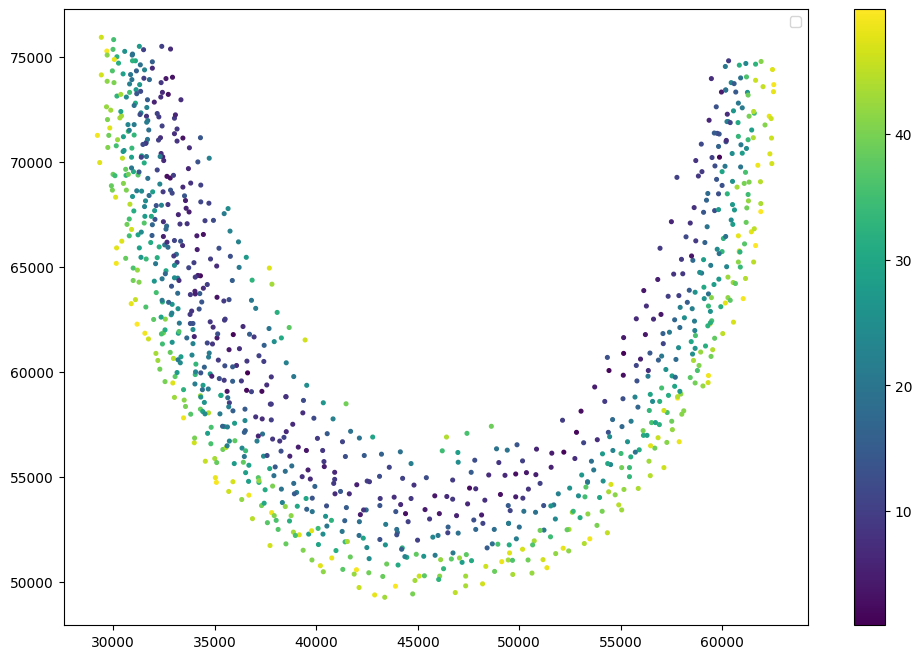

In [380]:
import pygsheets

gc = pygsheets.authorize(service_file = "./hippca3-8126bea0d603.json")
sheet = gc.open('all_pyramidal_cells')
worksheet = sheet.worksheet('title','all_pyr_v2_remove_dupes')
pc_df = worksheet.get_as_df()

nuclei_coord = pc_df[['x','y','z']].to_numpy()
depths = pc_df['depth_microns'].to_numpy()
#subgroup = (nuclei_coord[:,1] > 56000) & (nuclei_coord[:,1] < 65000)
#subgroup = (depths < 50) & (nuclei_coord[:,2] < 1900) 
subgroup = (depths < 50)
coord_filtered = nuclei_coord[subgroup,:]
depths_filtered = depths[subgroup]

plt.figure(figsize=(12,8))
sc = plt.scatter(coord_filtered[:,0], coord_filtered[:,1], s=7, c=depths_filtered, cmap='viridis', marker='o')
plt.colorbar(sc)
plt.legend()
plt.show()
